In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA
from dfply import *
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.multivariate.manova import MANOVA

In [2]:
# Analyse + fix missing values
data = pd.read_csv('prepared_data.csv', sep='\t', index_col=0)
print(data.isna().sum())
pd.set_option('use_inf_as_na',True)
data = data.dropna(how='any')

print(data.isna().sum())

error_rate           0
avg_char_duration    0
screen_size          0
swipe_finger         1
dtype: int64
error_rate           0
avg_char_duration    0
screen_size          0
swipe_finger         0
dtype: int64


***Boxplots without outliers removed***

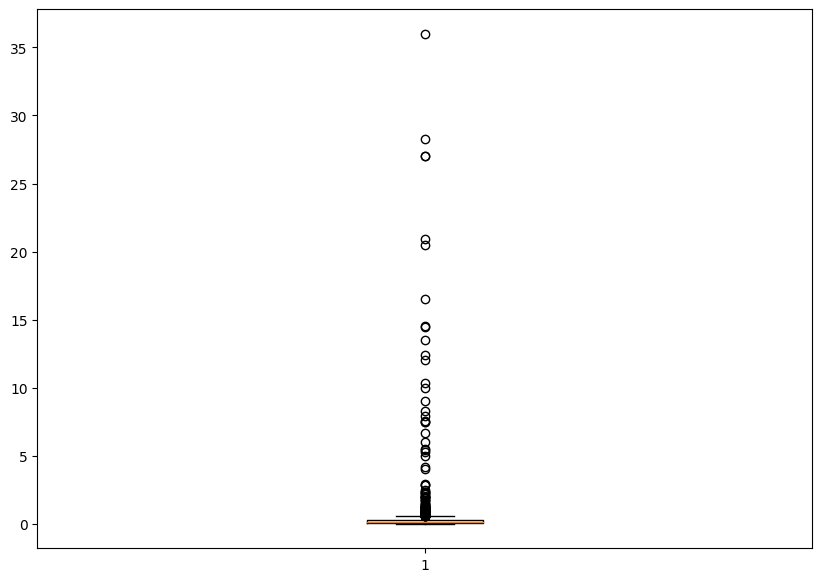

In [3]:
#box plot of error rate with no outliers removed
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data["error_rate"])
 
# show plot
plt.show()

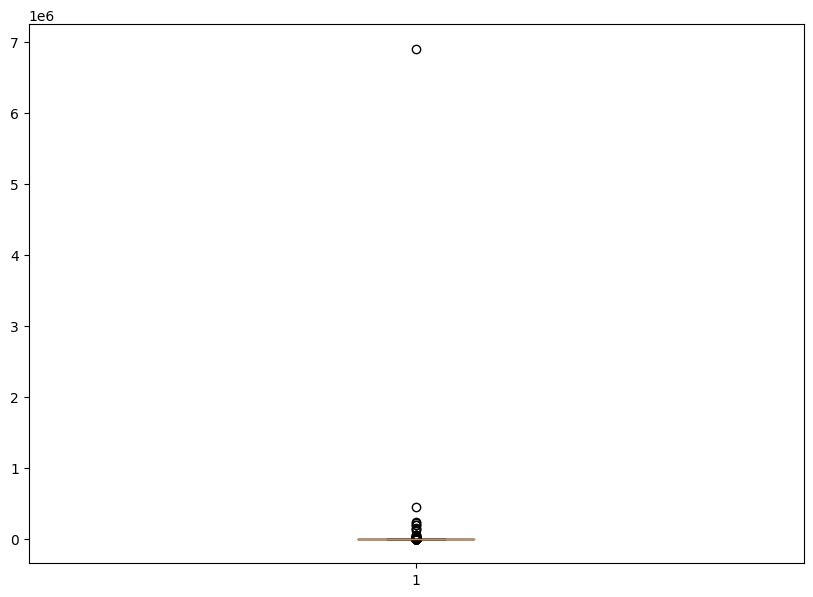

In [4]:
#box plot of average character durqation with no outliers removed
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data["avg_char_duration"])
 
# show plot
plt.show()

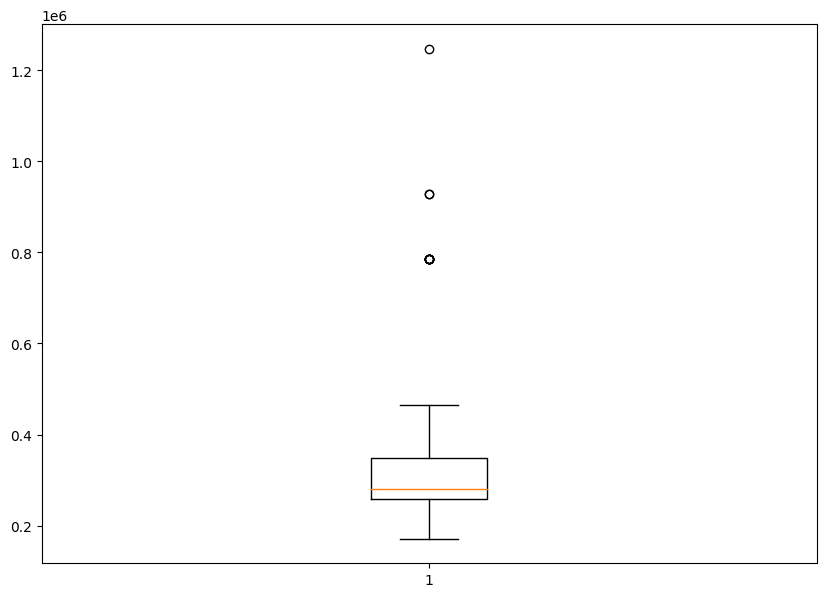

In [5]:
#box plot of screen size with no outliers removed
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data["screen_size"])
 
# show plot
plt.show()

Text(0.5, 1.06, 'Boxplot for all continuous variables in data set without outliers removed')

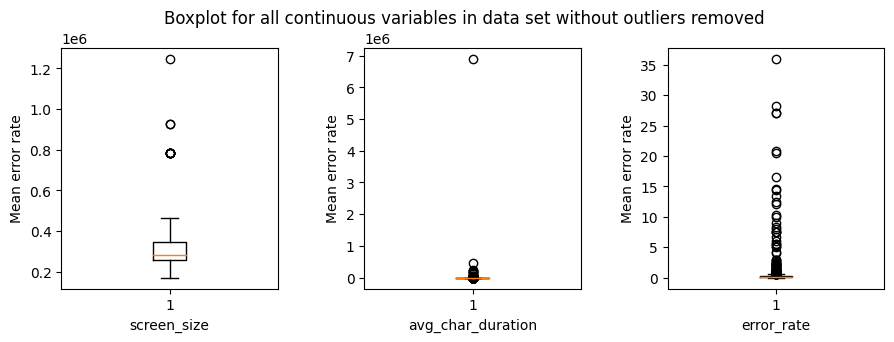

In [6]:
#combine plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
fig.tight_layout()

ax1.boxplot(data["screen_size"])
ax1.set_ylabel("Mean error rate")
ax1.set_xlabel("screen_size")

ax2.boxplot(data["avg_char_duration"])
ax2.set_ylabel("Mean error rate")
ax2.set_xlabel("avg_char_duration")

ax3.boxplot(data["error_rate"])
ax3.set_ylabel("Mean error rate")
ax3.set_xlabel("error_rate")

plt.subplots_adjust(wspace=0.4) 
 
fig.suptitle('Boxplot for all continuous variables in data set without outliers removed', y=1.06)

***Indicate and Remove outliers***

In [7]:
# Indicate outliers using Inter Quartile Range (IQR)
def find_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

# Function for removing outliers using Inter Quartile Range (IQR)
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


print("number of outliers in screen_size variable:", len(find_outliers_IQR(data['screen_size'])))
print("number of outliers in error_rate variable:", len(find_outliers_IQR(data['error_rate'])))
print("number of outliers in avg_char_duration variable:", len(find_outliers_IQR(data['avg_char_duration'])))

remove_outlier_screen = remove_outlier(data, 'screen_size')
remove_outlier_screen_error = remove_outlier(remove_outlier_screen, 'error_rate')
data_outliers_removed = remove_outlier(remove_outlier_screen_error, 'avg_char_duration')
print("Number of rows in dataframe before removing outliers:",len(data))
print("Number of rows in dataframe after removing outliers:",len(data_outliers_removed))

print("removed participants:",len(data) -  len(data_outliers_removed))

number of outliers in screen_size variable: 11
number of outliers in error_rate variable: 123
number of outliers in avg_char_duration variable: 209
Number of rows in dataframe before removing outliers: 1315
Number of rows in dataframe after removing outliers: 984
removed participants: 331


***Boxplot of variables with outliers removed***

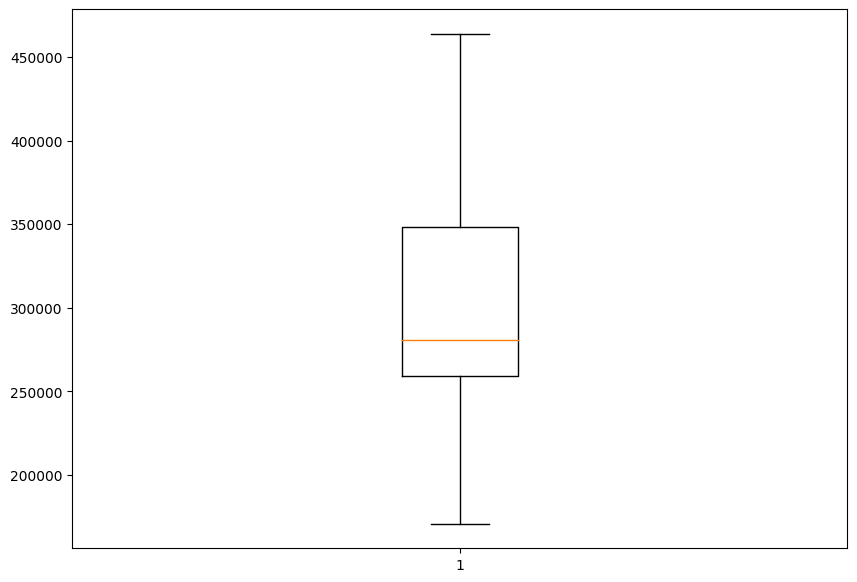

In [8]:
#box plot of screen_size with outliers removed
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data_outliers_removed["screen_size"])
 
# show plot
plt.show()

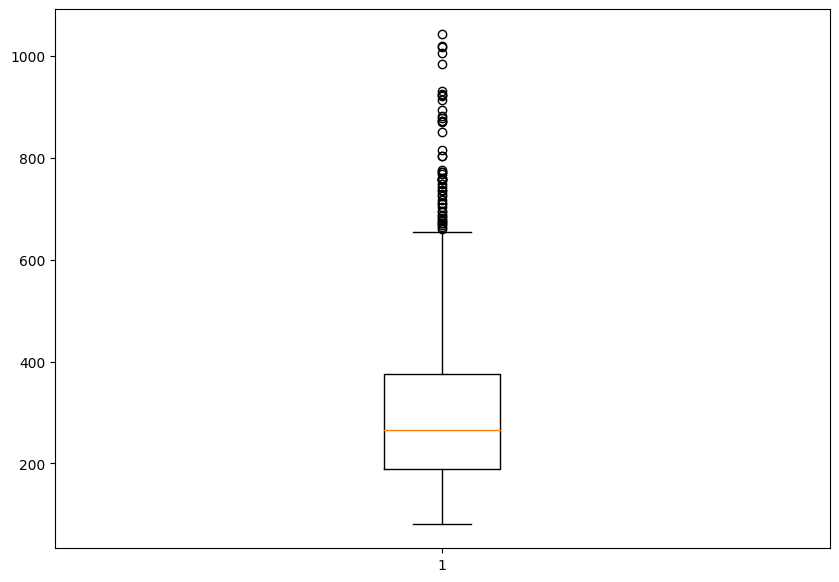

In [9]:
#box plot of avg_char_duration with outliers removed
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data_outliers_removed["avg_char_duration"])
 
# show plot
plt.show()

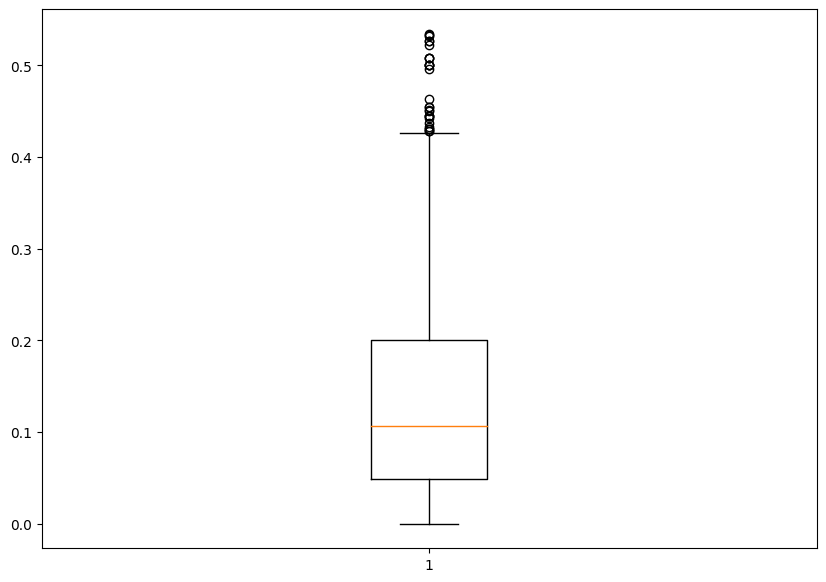

In [10]:
#box plot of error rate with outliers removed
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data_outliers_removed["error_rate"])
 
# show plot
plt.show()

Text(0.5, 1.06, 'Boxplot for all continuous variables in data set with outliers removed')

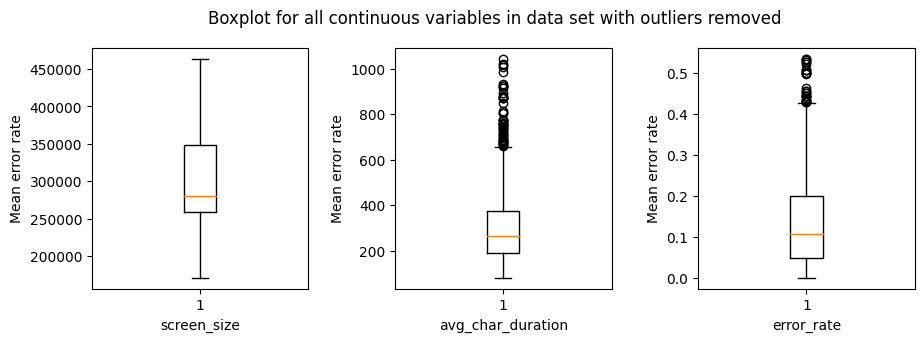

In [11]:
#combine plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
fig.tight_layout()

ax1.boxplot(data_outliers_removed["screen_size"])
ax1.set_ylabel("Mean error rate")
ax1.set_xlabel("screen_size")

ax2.boxplot(data_outliers_removed["avg_char_duration"])
ax2.set_ylabel("Mean error rate")
ax2.set_xlabel("avg_char_duration")

ax3.boxplot(data_outliers_removed["error_rate"])
ax3.set_ylabel("Mean error rate")
ax3.set_xlabel("error_rate")

plt.subplots_adjust(wspace=0.4) 
 
fig.suptitle('Boxplot for all continuous variables in data set with outliers removed', y=1.06)

***Split phone sizes***

- Note: Screen size was measured in CSS pixels by the JavaScript engine of the web browser, which are normalized pixels and do not depend on the physical screen density of the device. This way we ensure that the recorded screen sizes are comparable across devices and vendors.

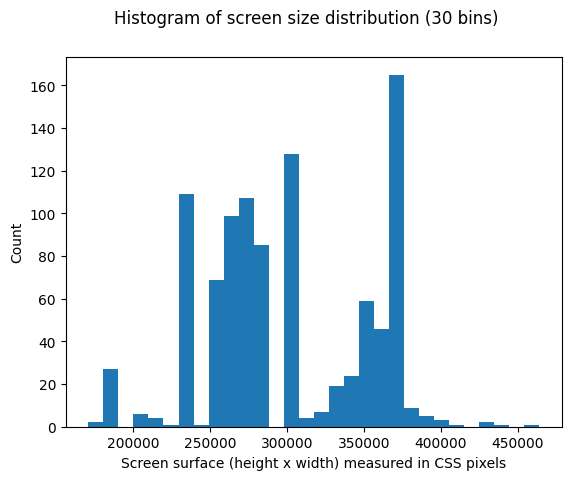

In [12]:
# Show distrubution of phone size in order to create split 
x = data_outliers_removed["screen_size"]
plt.hist(x, bins=30)
plt.suptitle("Histogram of screen size distribution (30 bins)")
plt.ylabel("Count")
plt.xlabel("Screen surface (height x width) measured in CSS pixels")
plt.show()

In [13]:
# Sort dataframe by screen surface values
size_sorted = data_outliers_removed.sort_values(by=['screen_size'])

# Split in two equal groups
splitted_sizes = np.array_split(size_sorted, 2)
screen_size_small = splitted_sizes[0]
screen_size_big = splitted_sizes[1]

print("length of dataframe screen_size: Small = ",len(screen_size_small.sort_values(by=['screen_size'])))
print("length of dataframe screen_size: Big = ",len(screen_size_big.sort_values(by=['screen_size'])))

# Change values of screen surface to two categorical values (small, big)
screen_size_small.loc[screen_size_small["screen_size"] > 0, 'screen_size'] = "Small"
screen_size_big.loc[screen_size_big["screen_size"] > 0, 'screen_size'] = "Big"

# Merge the two dataframes
merged_dataframe = screen_size_small.merge(screen_size_big, how = 'outer')

length of dataframe screen_size: Small =  492
length of dataframe screen_size: Big =  492


In [14]:
merged_dataframe

,error_rate,avg_char_duration,screen_size,swipe_finger
0,0.119048,600.847024,Small,Index
1,0.068966,563.154433,Small,Thumb
2,0.218750,118.143013,Small,Index
3,0.292308,168.026884,Small,Thumb
4,0.017241,330.398804,Small,Index
...,...,...,...,...
979,0.000000,290.069055,Big,Thumb
980,0.223881,346.092445,Big,Thumb
981,0.111111,218.085317,Big,Other
982,0.145161,132.640208,Big,Thumb


***number of rows in each category for swipe finger:***

In [15]:
print(len(merged_dataframe[merged_dataframe['swipe_finger'] == "Thumb"]))
print(len(merged_dataframe[merged_dataframe['swipe_finger'] == "Index"]))
print(len(merged_dataframe[merged_dataframe['swipe_finger'] == "Other"]))

656
276
52


***Check if data follows normal distribution***

In [16]:
# Use stats.shapiro to look if data is normally distributed

print("swipe_finger: Thumb -> error_rate:",stats.shapiro(merged_dataframe[merged_dataframe['swipe_finger'] == "Thumb"]['error_rate']))
print("swipe_finger: Index -> error_rate:",stats.shapiro(merged_dataframe[merged_dataframe['swipe_finger'] == "Index"]['error_rate']))
print("swipe_finger: Other -> error_rate:",stats.shapiro(merged_dataframe[merged_dataframe['swipe_finger'] == "Other"]['error_rate']))

print("swipe_finger: Thumb -> avg_char_duration:",stats.shapiro(merged_dataframe[merged_dataframe['swipe_finger'] == "Thumb"]['avg_char_duration']))
print("swipe_finger: Index -> avg_char_duration:",stats.shapiro(merged_dataframe[merged_dataframe['swipe_finger'] == "Index"]['avg_char_duration']))
print("swipe_finger: Other -> avg_char_duration:",stats.shapiro(merged_dataframe[merged_dataframe['swipe_finger'] == "Other"]['avg_char_duration']))

print("screen_size: Big -> error_rate:",stats.shapiro(merged_dataframe[merged_dataframe['screen_size'] == "Big"]['error_rate']))
print("screen_size: Small -> error_rate:",stats.shapiro(merged_dataframe[merged_dataframe['screen_size'] == "Small"]['error_rate']))

print("screen_size: Big -> avg_char_duration:",stats.shapiro(merged_dataframe[merged_dataframe['screen_size'] == "Big"]['avg_char_duration']))
print("screen_size: Small -> avg_char_duration:",stats.shapiro(merged_dataframe[merged_dataframe['screen_size'] == "Small"]['avg_char_duration']))


swipe_finger: Thumb -> error_rate: ShapiroResult(statistic=0.9004400968551636, pvalue=3.138258620540831e-20)
swipe_finger: Index -> error_rate: ShapiroResult(statistic=0.8842380046844482, pvalue=1.2292932242887605e-13)
swipe_finger: Other -> error_rate: ShapiroResult(statistic=0.9050453901290894, pvalue=0.0005476732039824128)
swipe_finger: Thumb -> avg_char_duration: ShapiroResult(statistic=0.8569122552871704, pvalue=6.109307642504706e-24)
swipe_finger: Index -> avg_char_duration: ShapiroResult(statistic=0.8756906390190125, pvalue=3.504728923525366e-14)
swipe_finger: Other -> avg_char_duration: ShapiroResult(statistic=0.924095869064331, pvalue=0.0026668289210647345)
screen_size: Big -> error_rate: ShapiroResult(statistic=0.8966464996337891, pvalue=1.0388409111820765e-17)
screen_size: Small -> error_rate: ShapiroResult(statistic=0.9034106731414795, pvalue=4.1537354224105565e-17)
screen_size: Big -> avg_char_duration: ShapiroResult(statistic=0.8474265933036804, pvalue=2.1513644970538375e

***Get means and standard deviations***
- In case you want to know the exact values of these

In [17]:
# Mean error_rate and standart deviation for two screen size categories
small_screen_error_rate_mean = merged_dataframe[merged_dataframe["screen_size"] == "Small"]['error_rate'].mean()
small_screen_error_rate_sd = merged_dataframe[merged_dataframe["screen_size"]  == "Small"]['error_rate'].std()
print('small screen - error_rate mean:',small_screen_error_rate_mean, "std:", small_screen_error_rate_sd)

big_screen_error_rate_mean = merged_dataframe[merged_dataframe["screen_size"]  == "Big"]['error_rate'].mean()
big_screen_error_rate_sd = merged_dataframe[merged_dataframe["screen_size"]  == "Big"]['error_rate'].std()
print('big screen - error_rate mean:',big_screen_error_rate_mean, "std:", big_screen_error_rate_sd)

# Mean avg_char_duration and standart deviation for two screen size categories
small_screen_avg_char_duration_mean = merged_dataframe[merged_dataframe["screen_size"] == "Small"]['avg_char_duration'].mean()
small_screen_avg_char_duration_sd = merged_dataframe[merged_dataframe["screen_size"]  == "Small"]['avg_char_duration'].std()
print('small screen - avg_char_duration mean:',small_screen_avg_char_duration_mean, "std:", small_screen_avg_char_duration_sd)

big_screen_avg_char_duration_mean = merged_dataframe[merged_dataframe["screen_size"]  == "Big"]['avg_char_duration'].mean()
big_screen_avg_char_duration_sd = merged_dataframe[merged_dataframe["screen_size"]  == "Big"]['avg_char_duration'].std()
print('big screen - avg_char_duration mean:',big_screen_avg_char_duration_mean, "std:", big_screen_avg_char_duration_sd)

# Mean error_rate and standart deviation for three swipe_finger categories
thumb_error_rate_mean = merged_dataframe[merged_dataframe["swipe_finger"] == "Thumb"]['error_rate'].mean()
thumb_error_rate_sd = merged_dataframe[merged_dataframe["swipe_finger"]  == "Thumb"]['error_rate'].std()
print('thumb swipe_finger - error_rate mean:',thumb_error_rate_mean, "std:", thumb_error_rate_sd)

index_error_rate_mean = merged_dataframe[merged_dataframe["swipe_finger"] == "Index"]['error_rate'].mean()
index_error_rate_sd = merged_dataframe[merged_dataframe["swipe_finger"]  == "Index"]['error_rate'].std()
print('index swipe_finger - error_rate mean:',index_error_rate_mean, "std:", index_error_rate_sd)

other_error_rate_mean = merged_dataframe[merged_dataframe["swipe_finger"]  == "Other"]['error_rate'].mean()
other_error_rate_sd = merged_dataframe[merged_dataframe["swipe_finger"]  == "Other"]['error_rate'].std()
print('other swipe_finger - error_rate mean:',other_error_rate_mean, "std:", other_error_rate_sd)

# Mean avg_char_duration and standart deviation for three swipe_finger categories
thumb_avg_char_duration_mean = merged_dataframe[merged_dataframe["swipe_finger"] == "Thumb"]['avg_char_duration'].mean()
thumb_avg_char_duratione_sd = merged_dataframe[merged_dataframe["swipe_finger"]  == "Thumb"]['avg_char_duration'].std()
print('thumb swipe_finger - avg_char_duration mean:',thumb_avg_char_duration_mean, "std:", thumb_avg_char_duratione_sd)

index_avg_char_duration_mean = merged_dataframe[merged_dataframe["swipe_finger"] == "Index"]['avg_char_duration'].mean()
index_avg_char_duration_sd = merged_dataframe[merged_dataframe["swipe_finger"]  == "Index"]['avg_char_duration'].std()
print('index swipe_finger - avg_char_duration mean:',index_avg_char_duration_mean, "std:", index_avg_char_duration_sd)

other_avg_char_duration_mean = merged_dataframe[merged_dataframe["swipe_finger"]  == "Other"]['avg_char_duration'].mean()
other_avg_char_duration_sd = merged_dataframe[merged_dataframe["swipe_finger"]  == "Other"]['avg_char_duration'].std()
print('other swipe_finger - avg_char_duration mean:',other_avg_char_duration_mean, "std:", other_avg_char_duration_sd)

small screen - error_rate mean: 0.15244710976191203 std: 0.12908036066585465
big screen - error_rate mean: 0.12407427899033198 std: 0.10576619739929503
small screen - avg_char_duration mean: 332.400652981393 std: 174.7887321659104
big screen - avg_char_duration mean: 284.2779935005805 std: 158.48988518482483
thumb swipe_finger - error_rate mean: 0.13757215746704704 std: 0.11664223843191389
index swipe_finger - error_rate mean: 0.13446789424174566 std: 0.11804503010328338
other swipe_finger - error_rate mean: 0.16707786840383484 std: 0.14555390170586768
thumb swipe_finger - avg_char_duration mean: 301.5623532176688 std: 166.04127539527403
index swipe_finger - avg_char_duration mean: 307.18383163910613 std: 160.03009322100945
other swipe_finger - avg_char_duration mean: 399.9664004989812 std: 214.01191895822993


***Visualize values with point plot including error bars using seaborn***
- Options: change translucent, change dotted line to solid line, change colors, change error bar tips, 

- These plots are very usefull when an extra variable will be used, because we can also use an extar line for Hue
- https://seaborn.pydata.org/generated/seaborn.pointplot.html

Text(0.5, 0.98, 'Mean error rate by screen size')

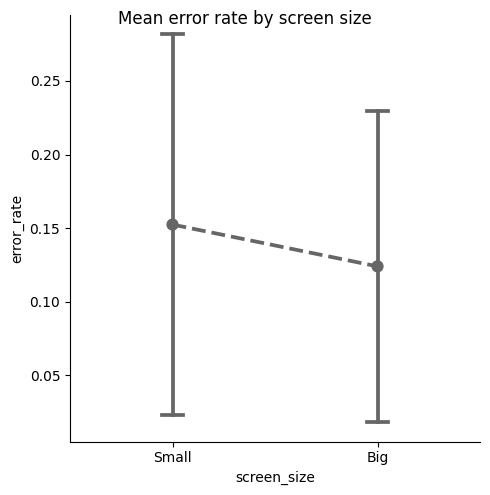

In [18]:
# Plot error rate for screen size
plot = sns.catplot(
    data=merged_dataframe, x="screen_size", y="error_rate", errorbar="sd",  capsize=.1, color=".4",
    markers=["o"], linestyles=["--"],
    kind="point"
)

plot.fig.suptitle('Mean error rate by screen size')

Text(0.5, 1.04, 'Mean average character duration by screen size')

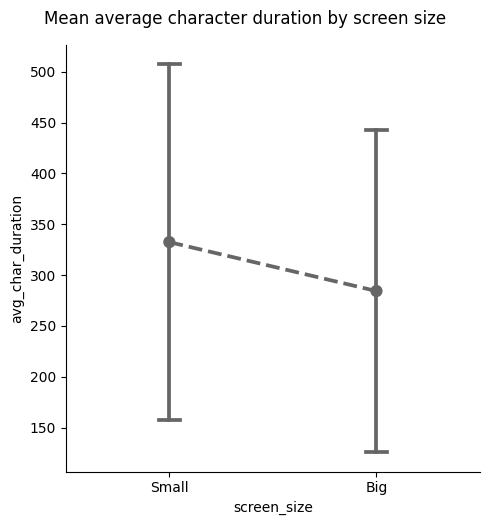

In [19]:
# Plot 
plot = sns.catplot(
    data=merged_dataframe, x="screen_size", y="avg_char_duration", errorbar="sd", capsize=.1, color=".4",
    markers=["o"], linestyles=["--"],
    kind="point"
)

plot.fig.suptitle('Mean average character duration by screen size', y=1.04)

Text(0.5, 1.04, 'Mean error rate by swipe finger')

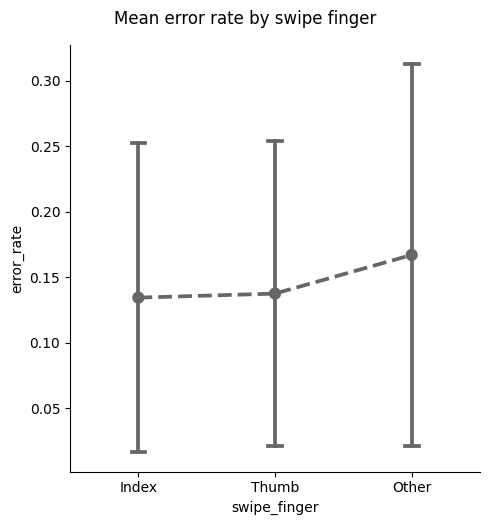

In [20]:
# Plot 
plot = sns.catplot(
    data=merged_dataframe, x="swipe_finger", y="error_rate", errorbar="sd", capsize=.1, color=".4",
    markers=["o"], linestyles=["--"],
    kind="point"
)

plot.fig.suptitle('Mean error rate by swipe finger', y=1.04)

Text(0.5, 1.04, 'Mean average character duration by swipe finger')

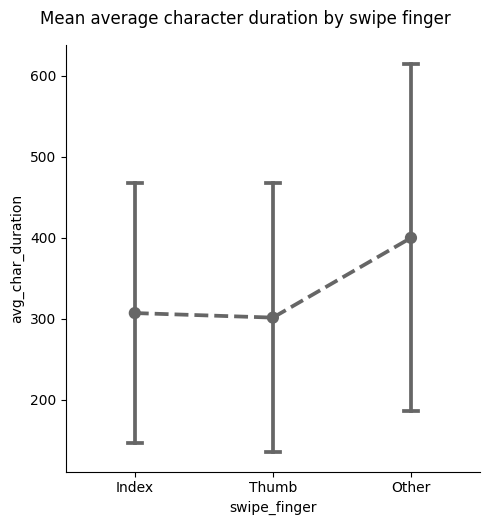

In [21]:
# Plot 
plot = sns.catplot(
    data=merged_dataframe, x="swipe_finger", y="avg_char_duration", errorbar="sd",  capsize=.1, color=".4",
    markers=["o"], linestyles=["--"],
    kind="point"
)

plot.fig.suptitle('Mean average character duration by swipe finger', y=1.04)

### ***Test significance***

In [22]:
# Test
#     Factorial Multivariate ANOVA
# Post hoc test 
#     Tukey of LDA

In [23]:
# Test of Multivariate MANOVA 
# links of examples:
# https://stats.stackexchange.com/questions/497956/multivariate-anova-in-python
# https://danvatterott.com/blog/2016/02/28/repeated-measures-anova-in-python-kinda/


maov=MANOVA.from_formula('error_rate + avg_char_duration ~ swipe_finger + screen_size', data=merged_dataframe)
print(maov.mv_test())


                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.5350 2.0000 979.0000 425.5104 0.0000
         Pillai's trace 0.4650 2.0000 979.0000 425.5104 0.0000
 Hotelling-Lawley trace 0.8693 2.0000 979.0000 425.5104 0.0000
    Roy's greatest root 0.8693 2.0000 979.0000 425.5104 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
      swipe_finger      Value  Num DF   Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.9782 4.0000 1958.0000  5.4272 0.0002
         Pillai's trace 0.0218 4.0000 1960.0000  5.4041 0.0003
 Hotelling-

***Post hoc Tukey HSD test***

- https://towardsdatascience.com/anova-tukey-test-in-python-b3082b6e6bda
- Null Hypothesis (H0) is a hypothesis that claims that there is no statistically significant relationship between variables
- Alternative Hypothesis (HA) claims that there is a statistically significant relationship between variables.
- So: where reject (H0) == True -> there is an significant pairwise difference

In [24]:
# Post hoc Tukey test on pairwise difference error_rate -- screensize

m_comp = pairwise_tukeyhsd(endog=merged_dataframe['error_rate'], groups=merged_dataframe['screen_size'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   Big  Small   0.0284 0.0002 0.0136 0.0431   True
--------------------------------------------------


In [25]:
# Post hoc Tukey test on pairwise difference error_rate -- swipe_finger

m_comp = pairwise_tukeyhsd(endog=merged_dataframe['error_rate'], groups=merged_dataframe['swipe_finger'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 Index  Other   0.0326 0.1645 -0.0095 0.0747  False
 Index  Thumb   0.0031 0.9294 -0.0169 0.0231  False
 Other  Thumb  -0.0295 0.1962 -0.0696 0.0106  False
---------------------------------------------------


In [26]:
# Post hoc Tukey test on pairwise difference error_rate -- interaction effect screen_size/swipe_finger

merged_dataframe['combination'] = merged_dataframe.screen_size + " / " + merged_dataframe.swipe_finger

m_comp = pairwise_tukeyhsd(endog=merged_dataframe['error_rate'], groups=merged_dataframe['combination'], alpha=0.05)
print(m_comp)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
  Big / Index   Big / Other   0.0245 0.9112 -0.0441 0.0932  False
  Big / Index   Big / Thumb  -0.0131 0.8838 -0.0472  0.021  False
  Big / Index Small / Index   0.0065 0.9974  -0.034  0.047  False
  Big / Index Small / Other   0.0501 0.4094 -0.0256 0.1258  False
  Big / Index Small / Thumb   0.0253 0.2757 -0.0087 0.0593  False
  Big / Other   Big / Thumb  -0.0376 0.5674 -0.1028 0.0276  False
  Big / Other Small / Index   -0.018 0.9757 -0.0868 0.0507  False
  Big / Other Small / Other   0.0256 0.9714 -0.0684 0.1195  False
  Big / Other Small / Thumb   0.0007    1.0 -0.0644 0.0659  False
  Big / Thumb Small / Index   0.0196 0.5779 -0.0147 0.0539  False
  Big / Thumb Small / Other   0.0632 0.1295 -0.0094 0.1358  False
  Big / Thumb Small / Thumb   0.0383 0.0005  0.0121 0.0646   True
Small / In

In [27]:
# Post hoc Tukey test on pairwise difference avg_char_duration -- screen_size

m_comp = pairwise_tukeyhsd(endog=merged_dataframe['avg_char_duration'], groups=merged_dataframe['screen_size'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   Big  Small  48.1227   0.0 27.2483 68.997   True
--------------------------------------------------


In [28]:
# Post hoc Tukey test on pairwise difference avg_char_duration -- swipe_finger

m_comp = pairwise_tukeyhsd(endog=merged_dataframe['avg_char_duration'], groups=merged_dataframe['swipe_finger'], alpha=0.05)
print(m_comp)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
 Index  Other  92.7826 0.0007   33.4388 152.1263   True
 Index  Thumb  -5.6215 0.8861  -33.7856  22.5426  False
 Other  Thumb  -98.404 0.0001 -154.9572 -41.8508   True
-------------------------------------------------------


In [29]:
# Post hoc Tukey test on pairwise difference avg_char_duration -- interaction effect screen_size/swipe_finger

m_comp = pairwise_tukeyhsd(endog=merged_dataframe['avg_char_duration'], groups=merged_dataframe['combination'], alpha=0.05)
print(m_comp)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------
  Big / Index   Big / Other   37.0625 0.8814  -59.1367 133.2618  False
  Big / Index   Big / Thumb   -7.6354 0.9975  -55.4141  40.1432  False
  Big / Index Small / Index   40.4173 0.3235  -16.3123   97.147  False
  Big / Index Small / Other  208.3963    0.0  102.3222 314.4705   True
  Big / Index Small / Thumb   35.9849 0.2585  -11.6206  83.5905  False
  Big / Other   Big / Thumb  -44.6979 0.7287 -136.0334  46.6375  False
  Big / Other Small / Index    3.3548    1.0  -92.9656  99.6751  False
  Big / Other Small / Other  171.3338 0.0029   39.7622 302.9054   True
  Big / Other Small / Thumb   -1.0776    1.0  -92.3226  90.1674  False
  Big / Thumb Small / Index   48.0527 0.0497    0.0306  96.0748   True
  Big / Thumb Small / Other  216.0317    0.0   114.348 317.7155   True
  Big 